Importing The Modules

In [29]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

Data Loading and Preprocessing

In [30]:
# Define the path to the dataset folders
happy_folder = "C:/Users/ramku/Downloads/QWERT/dataset/happy"
sad_folder = "C:/Users/ramku/Downloads/QWERT/dataset/Sad"
angry_folder = "C:/Users/ramku/Downloads/QWERT/dataset/Angry"


# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)


# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)


# Concatenate images and labels
X = np.array(happy_images + sad_images + angry_images)
y = np.array(happy_labels + sad_labels + angry_labels)

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = np_utils.to_categorical(y, 3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training and Evaluation

In [3]:
# Build the CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.summary())
# Compile the model with class weights
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

In [4]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}

In [5]:
# Train the model with class weights
history = model.fit(X_train.reshape(-1, 48, 48, 1), y_train, batch_size=32, epochs=100, validation_split=0.1, class_weight=class_weights,verbose=0)

In [6]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test.reshape(-1, 48, 48, 1), y_test)
losstr, accuracytr = model.evaluate(X_train.reshape(-1, 48, 48, 1), y_train)


# Save the trained model
model.save("facial_expression_model.h5")

19/19 [==============================] - 3s 139ms/step - loss: 0.4654 - accuracy: 0.9317


In [7]:
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Train accuracy: {accuracytr*100:.2f}%")

Test accuracy: 65.33%
Train accuracy: 93.17%


😻Testing the model on Pet's images

In [31]:
from keras.models import load_model

In [32]:
# Load the saved model
loaded_model = load_model("facial_expression_model.h5")

In [33]:
# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

In [34]:
# Load a custom test image
custom_test_image_path = "C:/Users/ramku/Downloads/dog.jpg"

In [35]:
custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

1/1 [==============================] - 0s 235ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [3.9806289e-10 2.9245324e-09 1.0000000e+00]


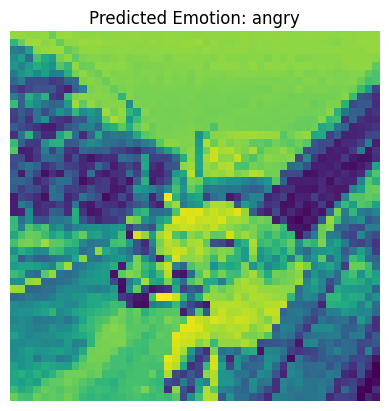

In [36]:
import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

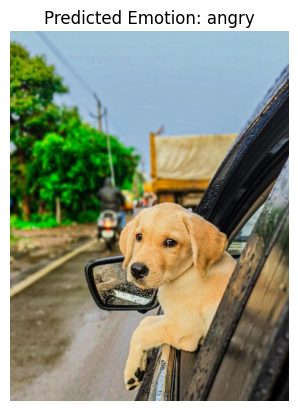

In [37]:
from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()